In [28]:
#Part 2 Renewable Potentials 
#First: Land eligibility analysis wind on shore
#Source buffers: https://boku.ac.at/fileadmin/data/H03000/H73000/H73200/TransWind/Flaechenpotentiale_Windkraftnutzung.pdf
#Source Land cover classes for Austria: https://www.parcs.at/nphtt/pdf_public/2014/30611_20141209_154737_CORINE_Nomenklatur.pdf
import geopandas as gpd
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np


excluder = ExclusionContainer(crs=3035, res=100)

#adding all sources
shape_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
protected_areas_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files=WDPA_Oct2022_Public_shp-AUT.tif"
copernicus_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files=PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-AT.tif"
elevation_url = "GEBCO_2014_2D-AT.nc"
airports_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_airports.gpkg"
roads_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_roads.gpkg"



In [29]:
countries = gpd.read_file(shape_url).set_index("name")
shape = countries.to_crs(excluder.crs).loc[["AT"]].geometry
shape = shape.to_crs(epsg=3035).geometry

In [30]:
#adding exclusion criteria for roads and airports as well as protection areas
excluder.add_geometry(roads_url, buffer= 300) #buffer 300 m
excluder.add_geometry(airports_url, buffer = 5100) #buffer 5100m (different because we found a source from transwind that suggested 5100 m)
excluder.add_raster(protected_areas_url, crs=3035)


In [ ]:
# exclusion codes for build up areas (cities or buildings near cities)
codes_urban = [50] #buffer 1000

#exclusion codes for water bodies and Wetlands and glaciers
codes_water_bodies_glaciers = [70, 80, 90] #1000 m buffer
#exclusion codes for woods becasue the suggestion of the document sais 
#they would exclude woods except of commercial forrest which can not be identified through the copernicus dataset
codes_woods = [111, 114, 115, 116, 121, 124, 125, 126]
#codes to include (can stil be excluded through natural protection areas)
codes_to_include = [20, 30, 40, 60, 100 ]

In [32]:
#adding exclusion from the CORINE dataset
#urban with 1000 m buffer (from suggestion paper)
excluder.add_raster(copernicus_url, codes=codes_urban, crs=3035, buffer=1000, nodata=255)

#for water bodies and Wetlands and glaciers with 1000m buffer 
excluder.add_raster(copernicus_url, codes=codes_water_bodies_glaciers, buffer= 1000, crs=3035, nodata=255)

#for woods 
excluder.add_raster(copernicus_url, codes=codes_woods,  crs=3035, nodata=255)
#adding inclusion codes
excluder.add_raster(copernicus_url, codes=codes_to_include, crs=3035, invert=True, nodata=255)

In [33]:
#getting the rasters for hights above 2000m
def exclude_above_2000m(raster):
    return raster > 2000
#exclude rasters over 2000m 
excluder.add_raster(elevation_url,crs=4326,codes=exclude_above_2000m)


In [34]:
#slope calculation and exclusion
def exclude_above_11deg(raster):
    
    dz_dy, dz_dx = np.gradient(raster, excluder.res, excluder.res)
    slope_deg = np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)))
    
    return slope_deg > 11.3

excluder.add_raster(elevation_url,crs=4326, codes=exclude_above_11deg)

c:\Users\Tobias\anaconda3\anaconda\envs\DSESM\Lib\site-packages\atlite\gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


<Axes: >

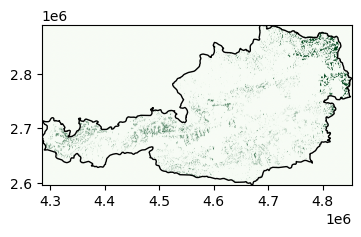

In [35]:
band, transform = shape_availability(shape, excluder)

fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax)

In [36]:
#for solar
excluder_solar = ExclusionContainer(crs=3035, res=100)

excluded_codes = [70, 80, 90, 100, 111, 114, 115, 116, 121, 124, 125, 126] 
included_codes = [50, 20, 30, 40, 60] 

In [37]:
excluder_solar.add_geometry(roads_url)
excluder_solar.add_geometry(airports_url)
excluder_solar.add_raster(protected_areas_url, crs=3035)
excluder_solar.add_raster(copernicus_url, codes=excluded_codes, crs=3035, nodata=255) 
excluder_solar.add_raster(copernicus_url, codes=included_codes, crs=3035, invert=True, nodata=255)

c:\Users\Tobias\anaconda3\anaconda\envs\DSESM\Lib\site-packages\atlite\gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


<Axes: >

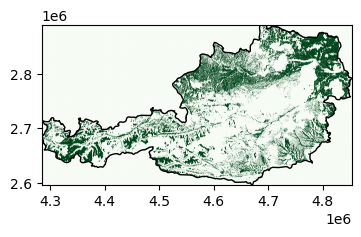

In [41]:
band_pv, transform_pv = shape_availability(shape, excluder_solar)

fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band_pv, transform=transform_pv, cmap="Greens", ax=ax)

In [ ]:
#area calculation for wind
eligible_cells = float(band.sum())
cell_area = float(excluder.res**2)
eligible_area = cell_area * eligible_cells
country_area = shape.geometry.area.iloc[0]
eligible_area #m^2


4159280000.0

In [42]:
eligible_cells_pv = float(band_pv.sum())
cell_area_pv = float(excluder_solar.res**2)
eligible_area_pv = cell_area_pv * eligible_cells_pv
country_area_pv = shape.geometry.area.iloc[0]
eligible_area_pv  #m^2


25759620000.0